In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from scipy.special import jv, kv
import dijet_utils as dutils


In [5]:
dj = dutils.DijetXsec()


In [11]:
pT_values = np.linspace(1,10,100)

vars = {'Q':np.sqrt(10), 'z': 0.4, 'x': 0.01, 's': 100**2, 'y':20/((100**2)*0.01), 'delta':0.2, 'phi_Dp':0.0, 'phi_kp':0.0}

test_dsa = np.array([dj.get_xsec({'pT': ipT} | vars, 'DSA') for ipT in pT_values])
test_unpolar = np.array([dj.get_xsec({'pT': ipT} | vars, 'unpolarized') for ipT in pT_values])


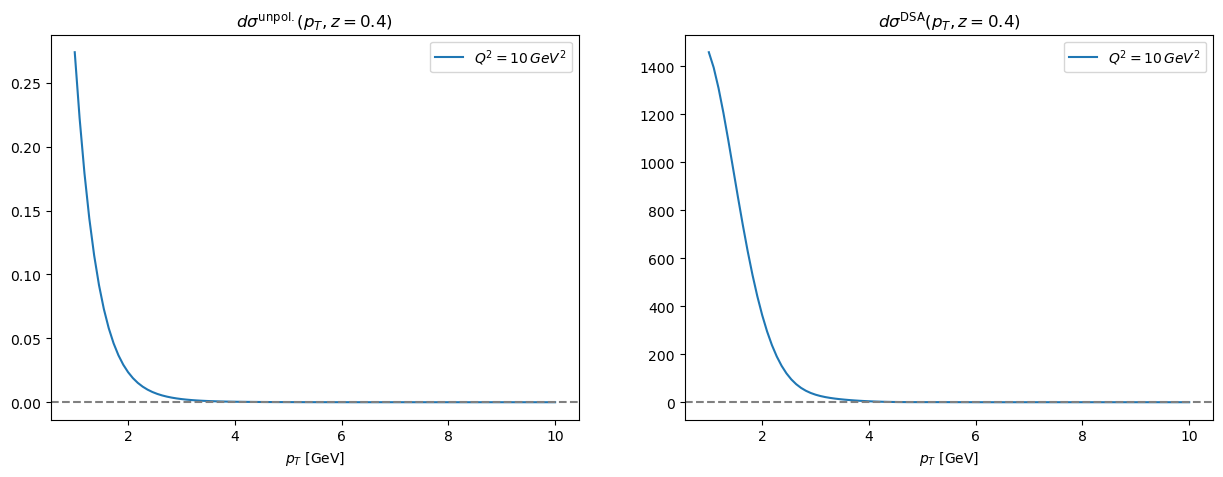

In [13]:
# plot pT spectrum
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(pT_values, test_unpolar, label = fr'$Q^2={round(vars['Q']**2)}\,GeV^2$')
axes[0].axhline(y=0, color='grey', linestyle='--')
axes[0].set_xlabel(r'$p_{T}$ [GeV]')
axes[0].set_title(fr'$d\sigma^{{\mathrm{{unpol.}}}}(p_T, z={vars['z']})$')
axes[0].legend()
# axes[0].semilogy()

axes[1].plot(pT_values, test_dsa, label = fr'$Q^2={round(vars['Q']**2)}\,GeV^2$')
axes[1].axhline(y=0, color='grey', linestyle='--')
axes[1].set_xlabel(r'$p_{T}$ [GeV]')
axes[1].set_title(fr'$d\sigma^{{\mathrm{{DSA}}}}(p_T, z={vars['z']})$')
axes[1].legend()
# axes[1].semilogy()

plt.show()

In [249]:
# compare IR regulating functions
pT_values = np.linspace(0,10,100)

test_Q2 = np.sqrt(5)
test_z = 0.4
test_r0 = 0.8

zetas_g = [5, 10, 20]
zetas_s = [1, 2, 3]
cuts = [0, -1, -2]

testQ_gauss = [np.array([double_bessel(ipT, test_Q2, test_z, 0.01, [0,0,0,0], 'Q', IR_reg = ['gauss', zeta]) for ipT in pT_values]) for zeta in zetas_g]
testQ_skin = [np.array([double_bessel(ipT, test_Q2, test_z, 0.01, [0,0,0,0], 'Q', IR_reg = ['skin', zeta, test_r0]) for ipT in pT_values]) for zeta in zetas_s]
testQ_cut = [np.array([double_bessel(ipT, test_Q2, test_z, 0.01, [0,0,0,0], 'Q', IR_reg = ['cut', icut]) for ipT in pT_values]) for icut in cuts]



/var/folders/ys/mxqhftx125v1xzgtytgqst140000gn/T/ipykernel_36931/2124446110.py:75: RuntimeWarning: overflow encountered in exp
  amp_values *= 1.0/(1 + np.exp(IR_reg[1]*((np.exp(u)/(lamIR*IR_reg[2])) - 1)))
/var/folders/ys/mxqhftx125v1xzgtytgqst140000gn/T/ipykernel_36931/2124446110.py:75: RuntimeWarning: overflow encountered in exp
  amp_values *= 1.0/(1 + np.exp(IR_reg[1]*((np.exp(u)/(lamIR*IR_reg[2])) - 1)))
/var/folders/ys/mxqhftx125v1xzgtytgqst140000gn/T/ipykernel_36931/2124446110.py:75: RuntimeWarning: overflow encountered in exp
  amp_values *= 1.0/(1 + np.exp(IR_reg[1]*((np.exp(u)/(lamIR*IR_reg[2])) - 1)))
/var/folders/ys/mxqhftx125v1xzgtytgqst140000gn/T/ipykernel_36931/2124446110.py:75: RuntimeWarning: overflow encountered in exp
  amp_values *= 1.0/(1 + np.exp(IR_reg[1]*((np.exp(u)/(lamIR*IR_reg[2])) - 1)))
/var/folders/ys/mxqhftx125v1xzgtytgqst140000gn/T/ipykernel_36931/2124446110.py:75: RuntimeWarning: overflow encountered in exp
  amp_values *= 1.0/(1 + np.exp(IR_reg[1]*((n

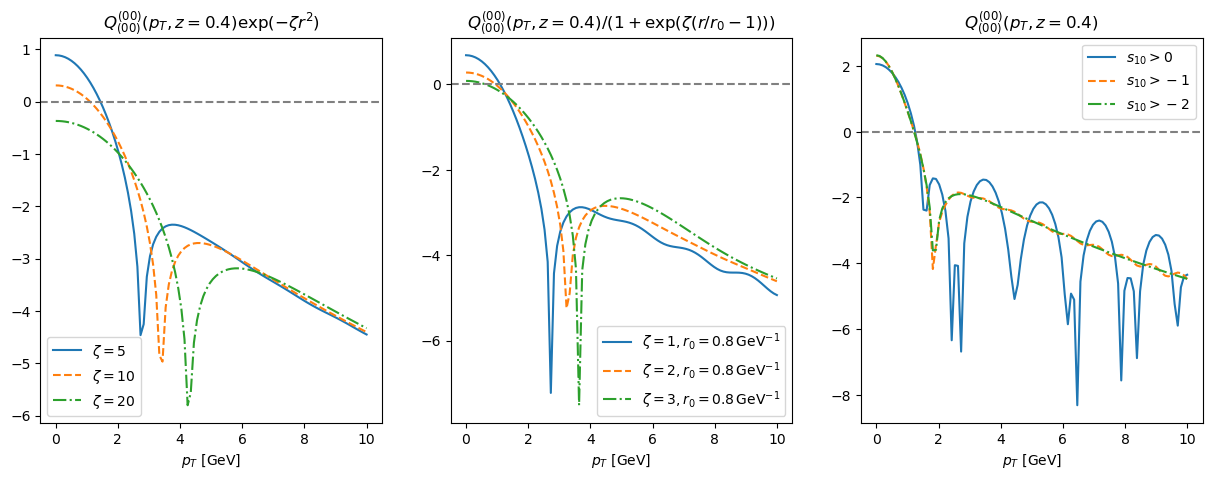

In [251]:
# IR regulator plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

lines = ['-', '--', '-.', ':']

for iz, zeta in enumerate(zetas_g):
    axes[0].plot(pT_values, np.log(np.abs(testQ_gauss[iz])), label = fr'$\zeta = {zeta}$', linestyle = lines[iz])

axes[0].axhline(y=0, color='grey', linestyle='--')
axes[0].set_xlabel(r'$p_{T}$ [GeV]')
axes[0].set_title(fr'$Q_{{(00)}}^{{(00)}}(p_T, z={test_z}) \exp(-\zeta r^2)$')
axes[0].legend()
# axes[0].semilogy()

for iz, zeta in enumerate(zetas_s):
    axes[1].plot(pT_values, np.log(np.abs(testQ_skin[iz])), label = fr'$\zeta = {zeta}, r_0 = {test_r0}\, \mathrm{{GeV}}^{{-1}}$', linestyle = lines[iz])

axes[1].axhline(y=0, color='grey', linestyle='--')
axes[1].set_xlabel(r'$p_{T}$ [GeV]')
axes[1].set_title(fr'$Q_{{(00)}}^{{(00)}}(p_T, z={test_z})/(1 + \exp(\zeta (r/r_0 -1)))$')
axes[1].legend()
# axes[0].semilogy()

for ic, cut in enumerate(cuts):
    axes[2].plot(pT_values, np.log(np.abs(testQ_cut[ic])), label = fr'$s_{{10}} > {cut}$', linestyle = lines[ic])

axes[2].axhline(y=0, color='grey', linestyle='--')
axes[2].set_xlabel(r'$p_{T}$ [GeV]')
axes[2].set_title(fr'$Q_{{(00)}}^{{(00)}}(p_T, z={test_z})$')
axes[2].legend()
# axes[0].semilogy()

plt.show()

fig.savefig(f"IR_regs{tag}.png")

In [304]:
# compute DSA for various kinematics
pT_values = np.linspace(1, 10, 100)

# vary Q2, xBj, z
Qs = [np.sqrt(5), np.sqrt(30), np.sqrt(35), np.sqrt(40)]
xBjs = [0.01, 0.001, 0.0001]
zs = [0.1, 0.2, 0.3, 0.4]

varied_data = {}
varied_data['Q2'] = {func.__name__: [[func(pT, Q, zs[-1], xBjs[0]) for pT in pT_values] for Q in Qs] for func in [A_TT, B_TT, A_LT, B_LT, C_LT]}
print('finished Q2')
varied_data['xBj'] = {func.__name__: [[func(pT, Qs[0], zs[-1], xBj) for pT in pT_values] for xBj in xBjs] for func in [A_TT, B_TT, A_LT, B_LT, C_LT]}
print('finished xBj')
varied_data['z'] = {func.__name__: [[func(pT, Qs[-1], z, xBjs[0]) for pT in pT_values] for z in zs] for func in [A_TT, B_TT, A_LT, B_LT, C_LT]}
print('finished z')

finished Q2
finished xBj
finished z


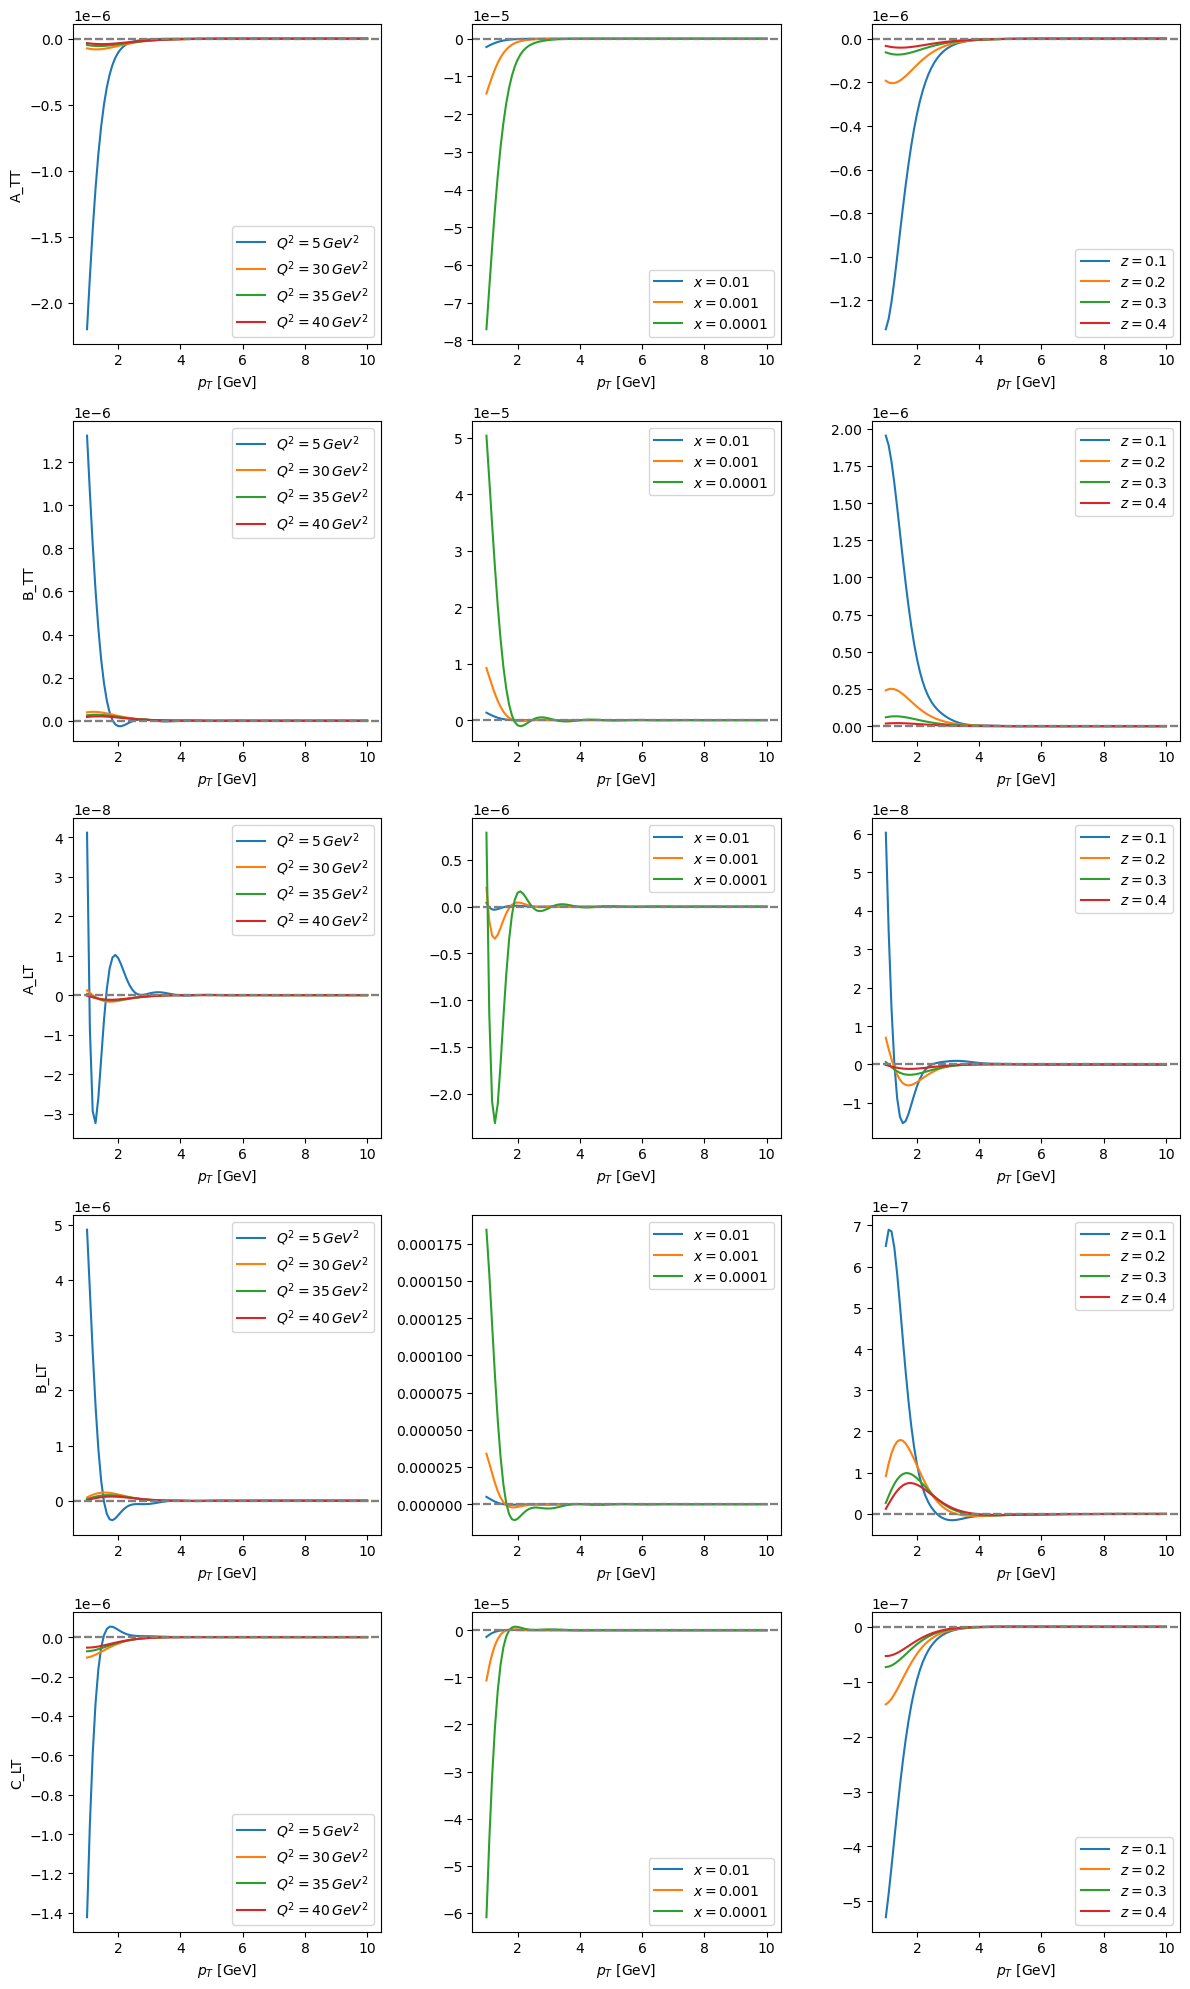

In [305]:
# plot variations

# amplitude plots
fig, axes = plt.subplots(5, 3, figsize=(12, 20))

for idist, dist in enumerate(['A_TT', 'B_TT', 'A_LT', 'B_LT', 'C_LT']):
    axes[idist,0].set_ylabel(dist)
    
    for iQ, Q in enumerate(Qs):
        axes[idist,0].plot(pT_values, varied_data['Q2'][dist][iQ], label = fr'$Q^2={round(Q**2)}\,GeV^2$')
        axes[idist,0].legend()
        axes[idist,0].axhline(y=0, color='grey', linestyle='--')
        axes[idist,0].set_xlabel(r'$p_T$ [GeV]')
        # axes[idist,0].semilogy()

    for ixBj, xBj in enumerate(xBjs):
        axes[idist,1].plot(pT_values, varied_data['xBj'][dist][ixBj], label = fr'$x={xBj}$')
        axes[idist,1].legend()
        axes[idist,1].axhline(y=0, color='grey', linestyle='--')
        axes[idist,1].set_xlabel(r'$p_T$ [GeV]')
        # axes[idist,1].semilogy()

    for iz, z in enumerate(zs):
        axes[idist,2].plot(pT_values, varied_data['z'][dist][iz], label = fr'$z={z}$')
        axes[idist,2].legend()
        axes[idist,2].axhline(y=0, color='grey', linestyle='--')
        axes[idist,2].set_xlabel(r'$p_T$ [GeV]')
        # axes[idist,2].semilogy()


plt.tight_layout()
plt.show()



In [310]:
# compute <1> and <cos\phi> 


test_z = 0.3
test_Q2 = np.sqrt(20)
test_y = 0.8

def amom(p, Q, z, x, y, func='1'):

    if func == '1': num = (2-y)*A_TT(p, Q, z, x)
    elif func == 'cosphi': num = 0.5*(2-y)*B_TT(p, Q, z, x)
    elif func == 'cospsi': num = 0.5*np.sqrt(2*(1-y))*A_LT(p, Q, z, x)
    elif func == 'coscos': num = 0.25*np.sqrt(2*(1-y))*B_LT(p, Q, z, x)
    elif func == 'sinsin': num = 0.25*np.sqrt(2*(1-y))*C_LT(p, Q, z, x)
    denom = (1+((1-y)**2))*A_TT_unpolar(p, Q, z, x) + 4*(1-y)*A_LL_unpolar(p, Q, z, x)

    return num/denom

pT_values = np.linspace(1, 10, 100)

# vary Q2, xBj, z
Qs = [np.sqrt(5), np.sqrt(20), np.sqrt(30), np.sqrt(40)]
xBjs = [0.01, 0.001, 0.0001]
zs = [0.1, 0.2, 0.3, 0.4]
moms = ['1', 'cosphi', 'cospsi', 'coscos', 'sinsin']

moms_varied_data = {}
moms_varied_data['Q2'] = {func: [[amom(pT, Q, zs[-1], xBjs[0], test_y, func=func) for pT in pT_values] for Q in Qs] for func in moms}
print('finished Q2')
moms_varied_data['xBj'] = {func: [[amom(pT, Qs[1], zs[-1], xBj, test_y, func=func) for pT in pT_values] for xBj in xBjs] for func in moms}
print('finished xBj')
moms_varied_data['z'] = {func: [[amom(pT, Qs[-1], z, xBjs[0], test_y, func=func) for pT in pT_values] for z in zs] for func in moms}
print('finished z')


finished Q2
finished xBj
finished z


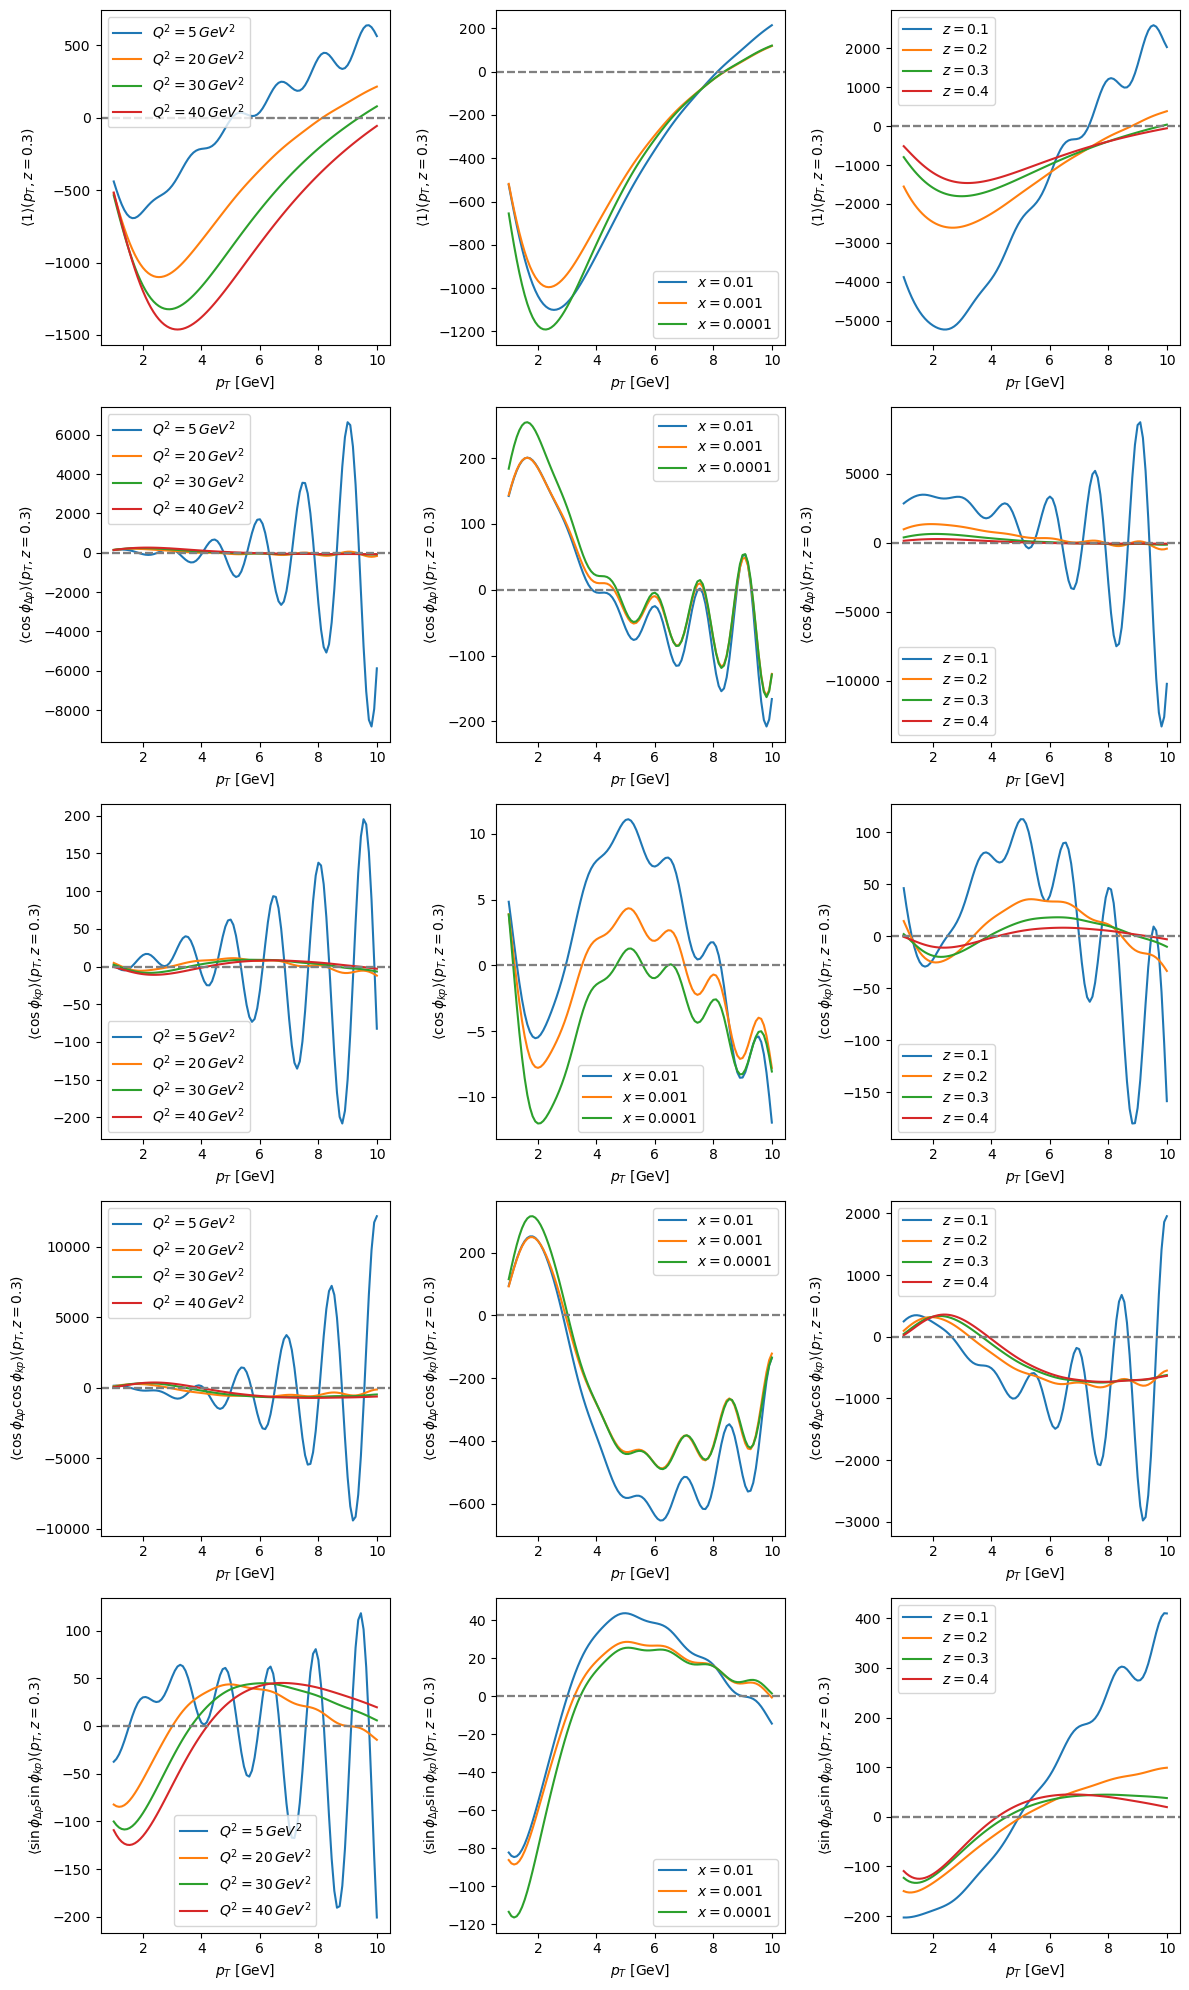

In [318]:
# plot azimuthal moments 

fig, axes = plt.subplots(5, 3, figsize=(12, 20))
titles = [fr'$\langle {it} \rangle (p_T, z={test_z})$' for it in ['1', '\\cos\\phi_{\\Delta p}', '\\cos\\phi_{k p}', '\\cos\\phi_{\\Delta p} \\cos\\phi_{k p}', '\\sin \\phi_{\\Delta p} \\sin \\phi_{k p}']]

for idist, dist in enumerate(moms):
    axes[idist,0].set_ylabel(dist)
    
    for iQ, Q in enumerate(Qs):
        axes[idist,0].plot(pT_values, moms_varied_data['Q2'][dist][iQ], label = fr'$Q^2={round(Q**2)}\,GeV^2$')
        axes[idist,0].legend()
        axes[idist,0].axhline(y=0, color='grey', linestyle='--')
        axes[idist,0].set_xlabel(r'$p_T$ [GeV]')
        # axes[idist,0].semilogy()
        axes[idist,0].set_ylabel(titles[idist])

    for ixBj, xBj in enumerate(xBjs):
        axes[idist,1].plot(pT_values, moms_varied_data['xBj'][dist][ixBj], label = fr'$x={xBj}$')
        axes[idist,1].legend()
        axes[idist,1].axhline(y=0, color='grey', linestyle='--')
        axes[idist,1].set_xlabel(r'$p_T$ [GeV]')
        # axes[idist,1].semilogy()
        axes[idist,1].set_ylabel(titles[idist])

    for iz, z in enumerate(zs):
        axes[idist,2].plot(pT_values, moms_varied_data['z'][dist][iz], label = fr'$z={z}$')
        axes[idist,2].legend()
        axes[idist,2].axhline(y=0, color='grey', linestyle='--')
        axes[idist,2].set_xlabel(r'$p_T$ [GeV]')
        # axes[idist,2].semilogy()
        axes[idist,2].set_ylabel(titles[idist])

plt.tight_layout()
plt.show()




In [1]:
[f'{i}{j}' for i in ['a', 'b', 'c'] for j in ['1', '2', '3']]

['a1', 'a2', 'a3', 'b1', 'b2', 'b3', 'c1', 'c2', 'c3']